# Introduction
This notebook analyses the data gathered from the Spotify API for the top 100 most streamed songs of all time on the Spotify platform ([Kaggle dataset](https://www.kaggle.com/datasets/amaanansari09/most-streamed-songs-all-time)). The main aim is to determine the most popular artists and song features amongst the hits, which could potentially be beneficial knowledge for music producers that aims to produce a hit song. The data also allowed for the prediction of a song's energy level based on its audio features, which can be helpful particularly as part of a music recommender system. For this, several machine learning models were built and tested on their prediction performance.

# Summary
The analysis showed that the most popular song features amongst all the hits included a tempo of around 110 bpm, loudness -6 dB, duration from 3 to 3.5 minutes and key C# major. The artist with the most total streams was Ed Sheeran, with 11.682 billions, whereas the artist with the most number of songs in the list was Justin Bieber with 6 apperances. The analysis also showed that older hits tend to be longer in duration compared to more recent ones and being written more in major keys. It was also found that songs which are predicted to be acoustic tend to be less loud and energetic.

Among the investigated regression models, support vector regression (SVR) was the most well fitted to the dataset to predict the energy level of a song, with a validation score of 64% and also performed relatively well on unseen test data with around 56% of the variation in energy successfully predicted by the model.

# *I. DATA CLEANING*

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [2]:
#IMPORTING THE DATASET
df_feat = pd.read_csv(r"Features.csv")
df_stre = pd.read_csv(r"Streams.csv")

In [3]:
df_stre.head(3)

,Song,Artist,Streams (Billions),Release Date
0,Blinding Lights,The Weeknd,3.449,29-Nov-19
1,Shape of You,Ed Sheeran,3.398,06-Jan-17
2,Dance Monkey,Tones And I,2.770,10-May-19


In [4]:
df_feat.head(3)

,id,name,duration,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,danceability
0,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,3.33,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,0.514
1,7qiZfU4dY1lWllzX7mPBI3,Shape of You,3.90,0.652,1,-3.183,0,0.0802,0.58100,0.000000,0.0931,0.931,95.977,0.825
2,2XU0oxnq2qxCpomAAuJY8K,Dance Monkey,3.49,0.588,6,-6.400,0,0.0924,0.69200,0.000104,0.1490,0.513,98.027,0.824


**Feature Description:**<br>
Obtained from the Spotify API:<br><br>
Song Properties:
- duration: measure of song duration in minutes
- key: the key the track is in: 0 to 11 (C, C#, D,..., A#, B)
- mode: modality of the track: 0 - Minor or 1 - Major. Mode usually goes with Key, for example a song is said to be in the key of A minor, G# major, etc.
- loudness: measured loudness of the track in decibels (dB)
- tempo: overall pace of the song in beats per minute (bpm)

Audio Features:
- energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. 
- speechiness: Detects the presence of spoken word in a track. speechiness > 0.66 represent talk shows, podcasts, etc., 0.33 to 0.66 represent genres such as rap, while lower than 0.33 the track most probably is music.
- acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- instrumentalness: Predicts whether a track is instrumental (containing no vocals). Values > 0.5 represent purely instrumental tracks, with confidence increasing the closer the value is to 1
- liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
- valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Values close to 1 represent
- danceability: 0 to 1, describes how suitable a track is for dancing. Values close to 1 means the track is very danceable.



### 1. Data Preparation:

Our dataset is relatively clean to work with, however, we need to address the following points before carrying out analysis:
- Artist column can contain multiple artists, which makes it difficult for artist analysis
- String data such as song name and artist are not formatted well with random extra spaces

In [5]:
#CREATING A GENERAL DATAFRAME BY MERGING THE TWO DATAFRAMES, FIRST CHECKING IF SONG NAMES ARE IDENTICAL IN EACH RECORD:
n=0
for i in range(0, df_feat.shape[0]):
    if df_feat.loc[i,'name'] == df_stre.loc[i,'Song']:
        n+=1
        
#IF ALL SONG NAMES MATCH, CREATE THE JOINED DATAFRAME, DROP ONE OF THE SONG NAME COLUMNS AND CREATE A NEW COLUMN 'RANK'
if n == df_feat.shape[0]:
    df = pd.concat([df_stre, df_feat], axis=1)
    df = df.drop('name',axis=1)
    df['rank'] = list(range(1, (df.shape[0]+1)))
else: print('error: mismatched data')

In [6]:
df.head(3)

,Song,Artist,Streams (Billions),Release Date,id,duration,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,danceability,rank
0,Blinding Lights,The Weeknd,3.449,29-Nov-19,0VjIjW4GlUZAMYd2vXMi3b,3.33,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,0.514,1
1,Shape of You,Ed Sheeran,3.398,06-Jan-17,7qiZfU4dY1lWllzX7mPBI3,3.90,0.652,1,-3.183,0,0.0802,0.58100,0.000000,0.0931,0.931,95.977,0.825,2
2,Dance Monkey,Tones And I,2.770,10-May-19,2XU0oxnq2qxCpomAAuJY8K,3.49,0.588,6,-6.400,0,0.0924,0.69200,0.000104,0.1490,0.513,98.027,0.824,3


In [7]:
#CREATE ARTIST 1,2,3 COLUMNS TO SEPARATE ARTISTS WHERE THERE ARE MORE THAN ONE ARTISTS IN ONE SONG:
def get_artist1(artists):
    all=artists
    all=all.replace('featuring',',').replace('and',',').replace('&',',').replace('with',',')
    list_all = all.split(',')
    return list_all[0].lstrip().rstrip()

def get_artist2(artists):
    all=artists
    all=all.replace('featuring',',').replace('and',',').replace('&',',').replace('with',',')
    list_all = all.split(',')
    if len(list_all)>1: return list_all[1].lstrip().rstrip()
    else: return 'No 2nd artist'

def get_artist3(artists):
    all=artists
    all=all.replace('featuring',',').replace('and',',').replace('&',',').replace('with',',')
    list_all = all.split(',')
    if len(list_all)>2: return list_all[2].lstrip().rstrip()
    else: return 'No 3rd artist'

df['Artist 1']=df['Artist'].apply(get_artist1)
df['Artist 2']=df['Artist'].apply(get_artist2)
df['Artist 3']=df['Artist'].apply(get_artist3)


In [8]:
#CORRECTING FOR "ARIANA GRANDE" WHICH WAS AFFECTED BY THE SPLIT WITH DELIMITER "AND"
df['Artist 1']=df['Artist 1'].str.replace('Ariana Gr', 'Ariana Grande')
df['Artist 2'].loc[df['Artist 1']=='Ariana Grande'] = 'No 2nd artist'

C:\Users\Zephyrus M15\AppData\Local\Temp\ipykernel_344\3449578465.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Artist 2'].loc[df['Artist 1']=='Ariana Grande'] = 'No 2nd artist'


In [9]:
#CONVERT 'RELEASE DATE' COLUMN INTO DATETIME64 DATA TYPE AND ADD A SONG AGE COLUMN:
df['Release Date'] = df['Release Date'].astype('datetime64[ns]')

#THE DATASET WAS LAST UPDATED ON 8/3/2023, CALCULATE THE AGE OF EACH SONG UP TO THIS DATE AND ASSIGN TO A COLUMN:
df['Song Age (Days)'] = -((pd.to_datetime('08-Mar-2023') - df['Release Date'])/np.timedelta64(1, 'D'))

In [10]:
#Cleaned dataset:
df.head()

,Song,Artist,Streams (Billions),Release Date,id,duration,energy,key,loudness,mode,...,instrumentalness,liveness,valence,tempo,danceability,rank,Artist 1,Artist 2,Artist 3,Song Age (Days)
0,Blinding Lights,The Weeknd,3.449,2019-11-29,0VjIjW4GlUZAMYd2vXMi3b,3.33,0.730,1,-5.934,1,...,0.000095,0.0897,0.334,171.005,0.514,1,The Weeknd,No 2nd artist,No 3rd artist,-1195.0
1,Shape of You,Ed Sheeran,3.398,2017-01-06,7qiZfU4dY1lWllzX7mPBI3,3.90,0.652,1,-3.183,0,...,0.000000,0.0931,0.931,95.977,0.825,2,Ed Sheeran,No 2nd artist,No 3rd artist,-2252.0
2,Dance Monkey,Tones And I,2.770,2019-05-10,2XU0oxnq2qxCpomAAuJY8K,3.49,0.588,6,-6.400,0,...,0.000104,0.1490,0.513,98.027,0.824,3,Tones And I,No 2nd artist,No 3rd artist,-1398.0
3,Someone You Loved,Lewis Capaldi,2.680,2018-11-08,7qEHsqek33rTcFNT9PFqLf,3.04,0.405,1,-5.679,1,...,0.000000,0.1050,0.446,109.891,0.501,4,Lewis Capaldi,No 2nd artist,No 3rd artist,-1581.0
4,Rockstar,Post Malone featuring 21 Savage,2.620,2017-09-15,0e7ipj03S05BNilyu5bRzt,3.64,0.520,5,-6.136,0,...,0.000070,0.1310,0.129,159.801,0.585,5,Post Malone,21 Savage,No 3rd artist,-2000.0


### 2. Examining our data:

In [11]:
df.dtypes

Song                          object
Artist                        object
Streams (Billions)           float64
Release Date          datetime64[ns]
id                            object
duration                     float64
energy                       float64
key                            int64
loudness                     float64
mode                           int64
speechiness                  float64
acousticness                 float64
instrumentalness             float64
liveness                     float64
valence                      float64
tempo                        float64
danceability                 float64
rank                           int64
Artist 1                      object
Artist 2                      object
Artist 3                      object
Song Age (Days)              float64
dtype: object

In [12]:
df.isnull().sum()

Song                  0
Artist                0
Streams (Billions)    0
Release Date          0
id                    0
duration              0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
danceability          0
rank                  0
Artist 1              0
Artist 2              0
Artist 3              0
Song Age (Days)       0
dtype: int64

No missing data

In [13]:
df.describe()

,Streams (Billions),duration,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,danceability,rank,Song Age (Days)
count,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.896000,3.635300,0.625500,5.340000,-6.17631,0.650000,0.096448,0.260955,0.007848,0.165682,0.502032,121.253900,0.649630,50.500000,-2857.510000
std,0.371272,0.807997,0.160045,3.627114,2.00858,0.479372,0.088872,0.272764,0.048977,0.122867,0.224953,29.544364,0.144618,29.011492,2700.837642
min,1.521000,1.520000,0.185000,0.000000,-12.20500,0.000000,0.028100,0.000025,0.000000,0.034400,0.061200,74.897000,0.340000,1.000000,-17295.000000
25%,1.647000,3.122500,0.523750,2.000000,-7.10375,0.000000,0.041200,0.026150,0.000000,0.094300,0.340750,98.022000,0.548000,25.750000,-2956.000000
50%,1.770500,3.505000,0.640000,6.000000,-5.97150,1.000000,0.059400,0.162500,0.000000,0.114000,0.492000,116.864000,0.671500,50.500000,-2200.500000
75%,2.046000,4.030000,0.741000,8.250000,-4.94075,1.000000,0.106000,0.431500,0.000086,0.217000,0.663000,142.439500,0.759250,75.250000,-1598.000000
max,3.449000,7.050000,0.912000,11.000000,-2.81000,1.000000,0.438000,0.945000,0.459000,0.790000,0.969000,186.003000,0.921000,100.000000,-341.000000


**Some insights:**
- 65 songs in the top 100 were written in a major mode
- The average song duration was 3 minutes 39 seconds
- The average loudness was -6.18 dB
- The slowest song had a tempo of around 75 bpm, the fastest 186 bpm
- The oldest song in the chart was released 17295 days ago - around 47 years and 4 months
- The top 100 songs generated a total of 189.6 billion streams for Spotify

In [14]:
#WE FIND HOW MANY TIMES EACH ARTIST APPEARED IN THE TOP 100:
artists_all = pd.concat([df['Artist 1'],df['Artist 2'],df['Artist 3']])
artists_all.value_counts()


No 3rd artist    96
No 2nd artist    67
Justin Bieber     6
Ed Sheeran        5
Post Malone       5
                 ..
Juice WRLD        1
Oasis             1
J. Cole           1
Lil Uzi Vert      1
MØ                1
Length: 91, dtype: int64

**Some insights:**
- 89 different artists made it to the top 100 most streamed songs on Spotify
- Justin Bieber topped the number of appearances in the top 100 with 6 songs

---

# *II. EXPLORATORY ANALYSIS*

### Problems Definition:
- Who are the top artists by most streams and number of songs?
- Is there a 'Recipe' for a top hit, i.e., a particularly popular key+mode combination, tempo range, song duration or loudness?
- Are there correlations between streams and audio featuress such as danceability, valence, acousticness,...
- Are there correlations between the features?


### 1. Find top artists

In [15]:
#CREATE A DATAFRAME WITH DATA FOR INDIVIDUAL ARTISTS:
artists = list(artists_all.unique())
artists.remove('No 2nd artist')
artists.remove('No 3rd artist')

artist_df = pd.DataFrame({'Artist': artists})
artist_df = artist_df.sort_values('Artist')
artist_df

,Artist
66,21 Savage
50,24kGoldn
41,Alan Walker
51,Arctic Monkeys
23,Ariana Grande
...,...
30,Vance Joy
61,Wiz Khalifa
68,Wizkid
20,XXXTentacion


In [16]:
#DEFINE FUNCTION TO FIND ALL SONGS BY EACH ARTIST AND CREATE A NEW COLUMN:
def find_songs(ar):
    songs = ''
    for i in df.index:
        if songs == '' and (df.loc[i, 'Artist 1']==ar or df.loc[i, 'Artist 2']==ar or df.loc[i, 'Artist 3']==ar):
            songs += str(df.loc[i, 'Song']).lstrip().rstrip()
        elif songs != '' and (df.loc[i, 'Artist 1']==ar or df.loc[i, 'Artist 2']==ar or df.loc[i, 'Artist 3']==ar):
            songs += ', '
            songs += str(df.loc[i, 'Song']).lstrip().rstrip()
    return songs

artist_df['Songs'] = artist_df['Artist'].apply(find_songs)

In [17]:
#DEFINE FUNCTION TO FIND RANK OF THE SONGS FOR EACH ARTIST AND CREATE A NEW COLUMN:
def find_ranks(ar):
    ranks = ''
    for i in df.index:
        if ranks == '' and (df.loc[i, 'Artist 1']==ar or df.loc[i, 'Artist 2']==ar or df.loc[i, 'Artist 3']==ar):
            ranks += str(df.loc[i, 'rank'])
        elif ranks != '' and (df.loc[i, 'Artist 1']==ar or df.loc[i, 'Artist 2']==ar or df.loc[i, 'Artist 3']==ar):
            ranks += ', '
            ranks += str(df.loc[i, 'rank'])
    return ranks

artist_df['Songs Chart Positions'] = artist_df['Artist'].apply(find_ranks)

In [18]:
#DEFINE FUNCTION TO CALCULATE NUMBER OF SONGS FOR EACH ARTIST AND CREATE A NEW COLUMN:
def total_songs(ar):
    total = 0
    for i in df.index:
        if df.loc[i, 'Artist 1']==ar or df.loc[i, 'Artist 2']==ar or df.loc[i, 'Artist 3']==ar:
            total += 1
    return total

artist_df['Number of Songs'] = artist_df["Artist"].apply(total_songs)

In [19]:
#DEFINE FUNCTION TO CALCULATE TOTAL STREAMS FOR EACH ARTIST AND CREATE A NEW COLUMN:
def calculate_total_streams(ar):
    total = 0
    for i in df.index:
        if df.loc[i, 'Artist 1']==ar or df.loc[i, 'Artist 2']==ar or df.loc[i, 'Artist 3']==ar:
            total += df.loc[i,'Streams (Billions)']
    return total

artist_df['Total Streams from Songs (Billions)'] = artist_df['Artist'].apply(calculate_total_streams)

In [20]:
#COMPLETED ARTIST DATAFRAME WITH RELEVANT STATS
artist_df.head()

,Artist,Songs,Songs Chart Positions,Number of Songs,Total Streams from Songs (Billions)
66,21 Savage,Rockstar,5,1,2.620
50,24kGoldn,Mood,78,1,1.628
41,Alan Walker,Faded,62,1,1.699
51,Arctic Monkeys,Do I Wanna Know?,79,1,1.627
23,Ariana Grande,"7 Rings, Thank U, Next","35, 74",2,3.576


**We can now find each artist and stats for their songs in the top 100. For example, was Coldplay in the chart, what songs specifically, and how many streams did these songs gather?**

In [21]:
index_df = artist_df.set_index('Artist')
print(index_df.loc['Coldplay'])

Songs                                  Something Just Like This, Yellow
Songs Chart Positions                                            25, 97
Number of Songs                                                       2
Total Streams from Songs (Billions)                               3.588
Name: Coldplay, dtype: object


**Which songs in the top 100 were accredited to Justin Bieber?**

In [22]:
print(index_df.loc['Justin Bieber','Songs'])

Stay, Love Yourself, Sorry, Let Me Love You, I Don't Care, Despacito (remix)


**We can now determine the top artists by most streams and by most number of songs in the top 100:**

In [23]:
#SORT artist_df BY TOTAL STREAMS:
streams = artist_df.sort_values('Total Streams from Songs (Billions)').reset_index()
streams = streams.drop('index',axis=1)
streams.tail()

,Artist,Songs,Songs Chart Positions,Number of Songs,Total Streams from Songs (Billions)
84,Dua Lipa,"Don't Start Now, New Rules, One Kiss, Levitating","19, 42, 53, 71",4,7.416
85,The Weeknd,"Blinding Lights, Starboy, The Hills","1, 15, 48",3,7.509
86,Post Malone,"Rockstar, Sunflower, Circles, Better Now, Cong...","5, 6, 30, 59, 61",5,10.598
87,Justin Bieber,"Stay, Love Yourself, Sorry, Let Me Love You, I...","9, 29, 52, 54, 75, 82",6,11.190
88,Ed Sheeran,"Shape of You, Perfect, Thinking Out Loud, Phot...","2, 12, 17, 23, 75",5,11.682


In [24]:
#PLOTTING TOP 10 ARTISTS BY TOTAL STREAMS
fig1 = go.Figure()
fig1.add_trace(go.Bar(x=streams.tail(10)['Total Streams from Songs (Billions)'],
                      y=streams.tail(10)['Artist'],
                      orientation='h',
                      marker=dict(color='Orange')))
fig1.update_layout(autosize=False, width=1200, height=500,
                   title="Top 10 Artists by Total Streams from their Songs in the Top 100",
                   xaxis_title="Streams (Billions)",
                   yaxis_title="Artist",)
fig1.show()

In [25]:
#SORT artist_df BY SONG COUNT FIRST:
count = artist_df.sort_values(['Number of Songs','Total Streams from Songs (Billions)'],ascending=False).reset_index()
count = count.drop('index',axis=1)
count.head()

,Artist,Songs,Songs Chart Positions,Number of Songs,Total Streams from Songs (Billions)
0,Justin Bieber,"Stay, Love Yourself, Sorry, Let Me Love You, I...","9, 29, 52, 54, 75, 82",6,11.190
1,Ed Sheeran,"Shape of You, Perfect, Thinking Out Loud, Phot...","2, 12, 17, 23, 75",5,11.682
2,Post Malone,"Rockstar, Sunflower, Circles, Better Now, Cong...","5, 6, 30, 59, 61",5,10.598
3,Dua Lipa,"Don't Start Now, New Rules, One Kiss, Levitating","19, 42, 53, 71",4,7.416
4,Shawn Mendes,"Señorita, Treat You Better, There's Nothing Ho...","11, 57, 89, 90",4,7.228


In [26]:
#PLOTTING TOP 10 ARTISTS BY NUMBER OF SONGS IN THE TOP 100
fig2 = go.Figure()
fig2.add_trace(go.Bar(y=count.head(10)['Number of Songs'],
                      x=count.head(10)['Artist'],
                      marker=dict(color='Turquoise')))
fig2.update_layout(autosize=False, width=1100, height=500,
                   title="Top 10 Artists by Most Number of Songs in the Top 100",
                   yaxis_title="Song Count",
                   xaxis_title="Artist",)
fig2.show()

**Insights:**
- Justin Bieber was the only artist who had 6 songs in the top 100, followed by Ed Sheeran and Post Malone with 5 each, followed by Dua Lipa and Shawn Mendes with 4 each. All other artists had 3 songs or less in the top 100.
- Despite not having the most songs, Ed Sheeran was the most streamed artist, with a total of 11.682 billion streams from his songs in the top 100 such as Shape of You, Perfect, etc.
- There was a significant gap between the top 3 streamed artists and the rest: only Ed Sheeran, Justin Bieber and Post Malone had more than 10 billion total streams, while the rest of the artists have less than 8 billions.

### 2. Determine the 'Pop Recipe': ideal tempo, key, loudness, and song duration

In [27]:
#WE DEFINE THE TEMPO RANGES AND CALCULATE THE TOTAL SONG STREAMS FOR THAT RANGE:
tempo_intervals = np.arange(70,195,10)
tempo_data=df.groupby(pd.cut(df['tempo'], tempo_intervals))['Streams (Billions)'].sum().reset_index()

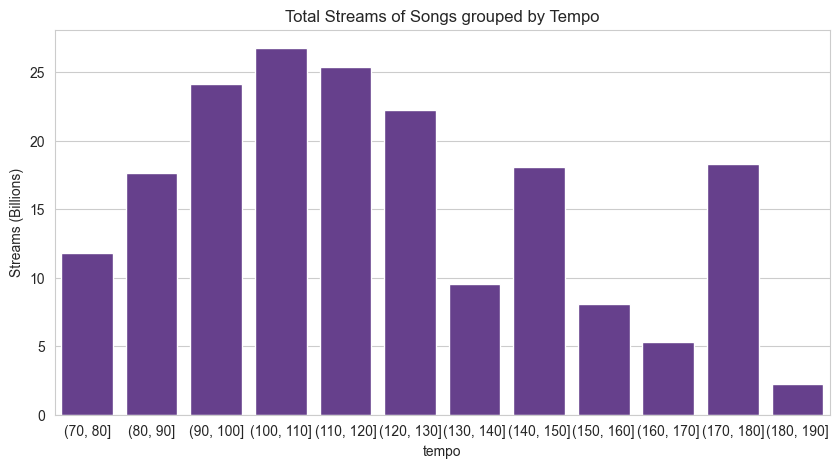

In [28]:
#PLOT STREAMS AGAINST EACH TEMPO RANGES:
plt.figure(figsize=(10,5))
sns.set_style('whitegrid')
sns.barplot(tempo_data,x='tempo',y='Streams (Billions)',color='RebeccaPurple')
plt.title('Total Streams of Songs grouped by Tempo')
plt.show()

**Insights:**
Song tempo from 90 to 130 is the most appealing to the mainstream, although 140-150 and 170-180 bpm songs are also popular

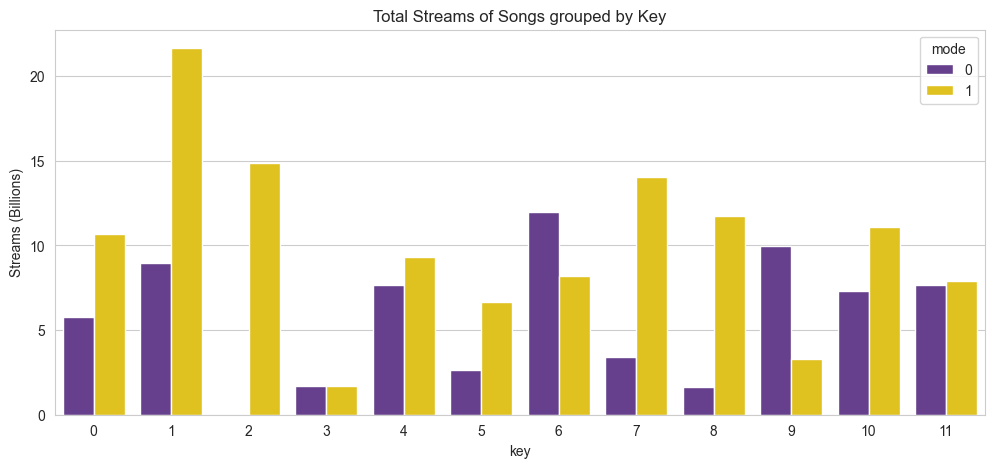

In [29]:
#FIND TOTAL STREAMS FOR EACH KEY+MODE COMBINATION AND PLOT:
key_data = df.groupby(['key','mode'])['Streams (Billions)'].sum().reset_index()
plt.figure(figsize=(12,5))
sns.set_style('whitegrid')
sns.barplot(key_data,x='key',y='Streams (Billions)',hue='mode',palette=['rebeccapurple', 'gold'])
plt.title('Total Streams of Songs grouped by Key')
plt.show()

**Insights:**
- No song in the top 100 was written in D minor
- C# major was significantly more popular than other keys. A possible explanation could be that it showcases best the vocal range of most artists.

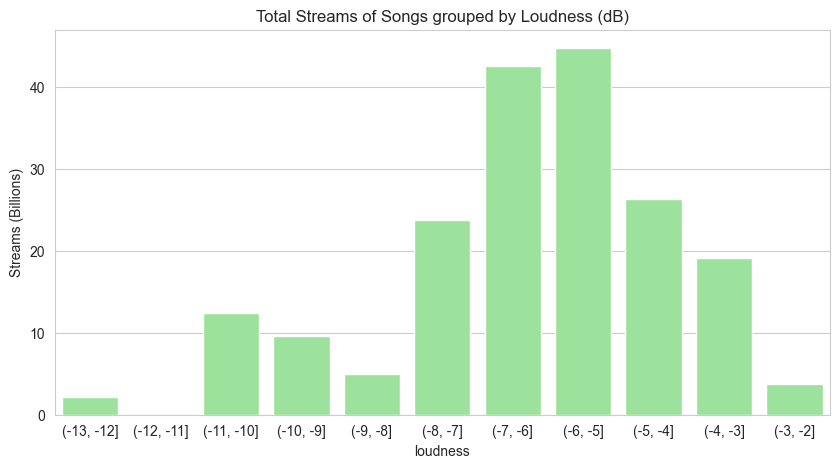

In [30]:
#GROUP DATA BY LOUDNESS RANGE AND PLOT STREAMS FOR EACH RANGE:
loud_int = np.arange(-13,-1,1)
loud_data = df.groupby(pd.cut(df['loudness'], loud_int))['Streams (Billions)'].sum().reset_index()
plt.figure(figsize=(10,5))
sns.set_style('whitegrid')
sns.barplot(loud_data,x='loudness',y='Streams (Billions)', palette=['LightGreen'])
plt.title('Total Streams of Songs grouped by Loudness (dB)')
plt.show()

**Insights:**
Most appealing to the mainstream are songs that are between -7 and -5 dB, which account for nearly 90 billion streams - almost half the grand total of all 100 songs. This can be said to be a safe loudness interval if/when a producer is not sure how loud to master their new track. We will further investigate loudness in the next section.

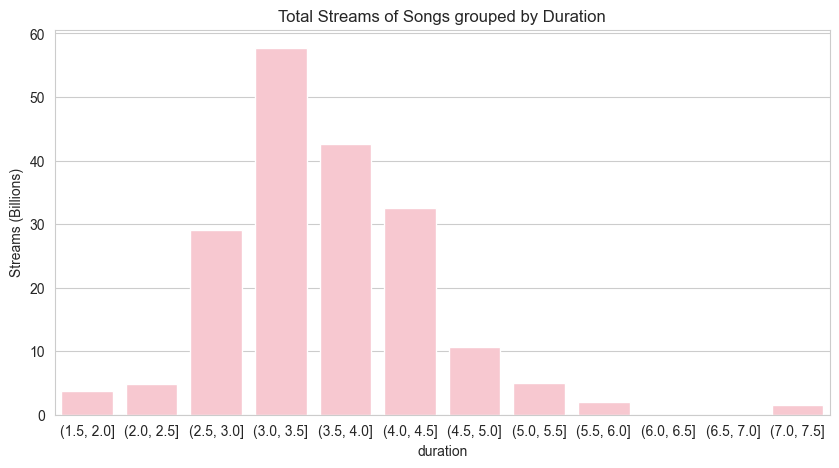

In [31]:
#GROUP SONGS BY DURATION AND PLOT STREAMS:
dur_int = np.arange(1.5,7.6,0.5)
dur_data = df.groupby(pd.cut(df['duration'],dur_int))['Streams (Billions)'].sum().reset_index()
plt.figure(figsize=(10,5))
sns.set_style('whitegrid')
sns.barplot(dur_data,x='duration',y='Streams (Billions)', palette=['Pink'])
plt.title('Total Streams of Songs grouped by Duration')
plt.show()

**Insights:** 
The majority of the songs in the chart are between 2.5 and 4.5 minutes long. This result is to be expected because songs shorter than 2.5 minutes are often not fully developed in terms of musical structure, while songs longer than 4.5 minutes are often too long for radio time/human attention span, where people will start to lose interest. We can gain more insights about song duration in the next section.

### 3. Investigate Correlations:

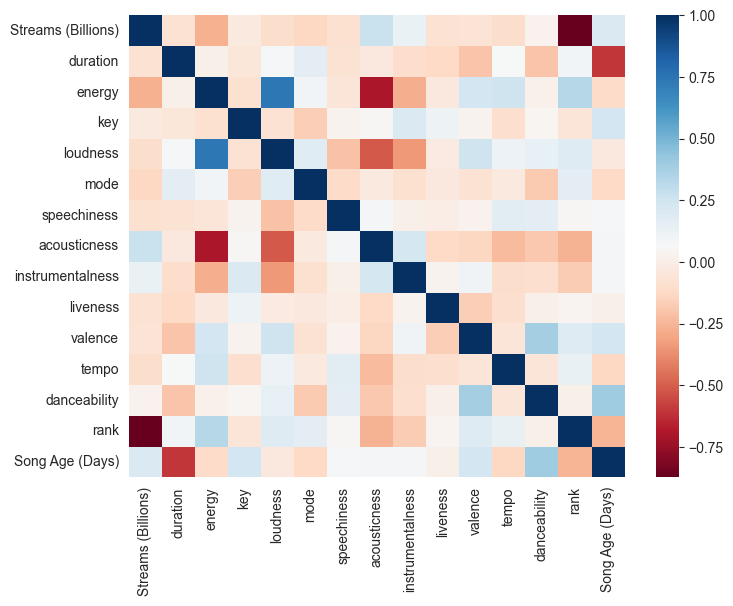

In [32]:
#PLOT HEAT MAP OF CORRELATION BETWEEN ALL VARIABLES:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), cmap='RdBu')
plt.show()

From the heat map above, we can see 'Streams (Billions)' had no significant correlations with any other variable (apart from the obvious correlation with rank and itself). However, there are some noticeable correlations between some of the other song features:
- energy with loudness and acousticness
- Song Age (Days) and duration

**First, we inspect Song Age (Days) to see trends over time:**

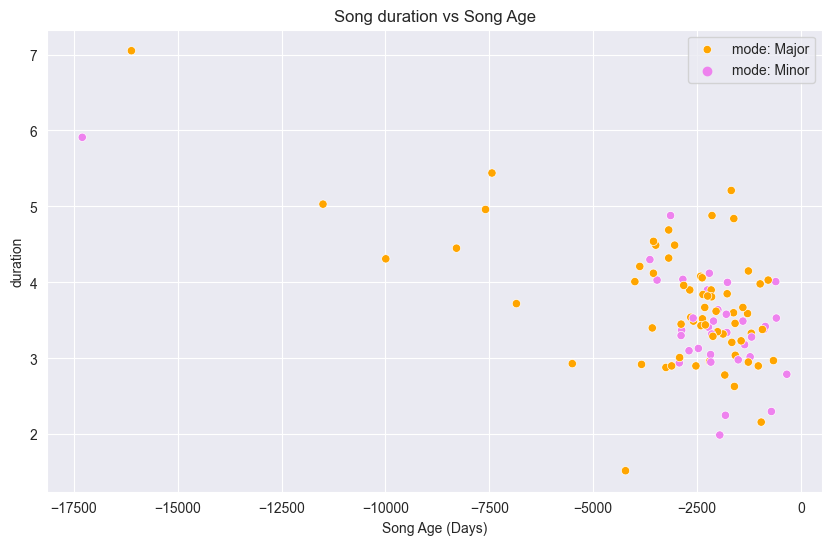

In [33]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
sns.scatterplot(df,y='duration',x='Song Age (Days)',hue='mode',palette=['violet','orange'])
plt.legend(['mode: Major','mode: Minor'],loc='upper right')
plt.title('Song duration vs Song Age')
plt.show()

**Insights:** 
- Song duration decreased over time, i.e., recent hits tend to be shorter in duration compared to older hits. Furthermore, if we color-code the datapoints with the mode of the songs, we can see that songs in the chart which were released more than 4000 days ago (~11 years) were almost exclusively songs in a major key.
- The majority of top streamed songs were released less than a decade ago.

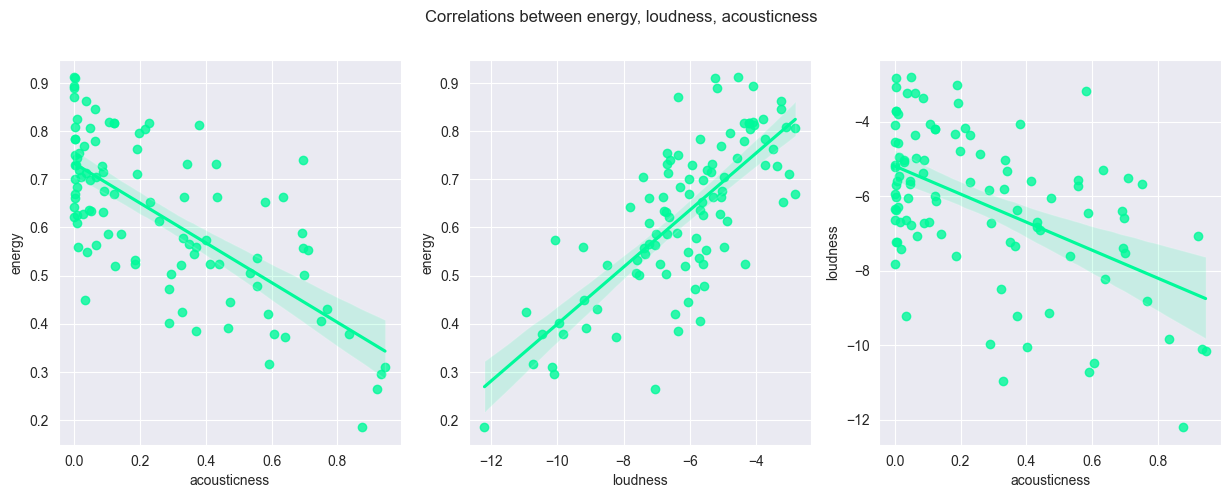

In [34]:
#PLOTTING ENERGY VS LOUDNESS VS ACOUSTICNESS
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
sns.set_style("dark")
sns.regplot(df,x='acousticness',y='energy',color='mediumspringgreen',ax=ax1)
sns.regplot(df,x='loudness',y='energy',color='mediumspringgreen',ax=ax2)
sns.regplot(df,y='loudness',x='acousticness',color='mediumspringgreen',ax=ax3)
plt.suptitle('Correlations between energy, loudness, acousticness')
plt.show(fig1)

We find that loudness and energy are strongly and positively correlated, and songs that are predicted to be acoustic tend to be more quiet and less energetic.

# *III. PREDICTIVE ANALYSIS*

In this section we try to develop a model that aims to predict the perceived energy level of a song based on its audio feature, which could be helpful as part of a recommender or playlist-building system. We will tune and assess the performance of the following models:
- Linear Regression
- Ridge Regression
- Support Vector Regression (SVR)

In [35]:
#IMPORTS:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import sklearn.metrics

In [36]:
#Create a dataframe to record each model's performance:
model_scores = pd.DataFrame({'Model':[],'Score Type':[],'R-squared':[]})

In [37]:
#PREPARE THE DATA:
#We use 'acousticness' and 'loudness' as independent variables since only these have significant correlations with 'energy'. Adding more features will result in the introduction of noise in the data
x=df[['acousticness','loudness']]
y=df['energy']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)

### 1. Linear Regression (LR):

In [38]:
#LINEAR REGRESSION MODEL
#Building the model:
pipe = Pipeline([('scaler',StandardScaler()),('poly',PolynomialFeatures()),('model',LinearRegression())])
params = {'model__fit_intercept':[True,False],
          'poly__degree':[1,2,3]
          }
grid1 = GridSearchCV(pipe,params,cv=5)

#Fit the data:
grid1.fit(x_train,y_train)

#Evaluate the best model:
y_pred = grid1.predict(x_test)
rsq = sklearn.metrics.r2_score(y_test,y_pred)
mse = sklearn.metrics.mean_squared_error(y_test,y_pred)
print('Best Parameters: {}\nBest Validation Score: {}\nTest Score: {}\nMean Squared Error: {}\n'.format(grid1.best_params_,grid1.best_score_,rsq,mse))

#Record the perfomance:
model_scores.loc[0] = ['LR','Val',grid1.best_score_]
model_scores.loc[1] = ['LR','Test',rsq]

Best Parameters: {'model__fit_intercept': True, 'poly__degree': 1}
Best Validation Score: 0.6230870659143342
Test Score: 0.519179767213368
Mean Squared Error: 0.00923835854565357



### 2. Ridge Regression (RR):

Since there might be colinearity between acousticness and loudness as investigated in the previous section, we try using Ridge to see if any improvements in prediction precision could be made

In [39]:
#RIDGE REGRESSION MODEL:
#Build the model:
pipe = Pipeline([('scaler',StandardScaler()),('poly',PolynomialFeatures()),('model',Ridge())])
params = {'poly__degree':[1,2,3],
          'model__alpha':[3,4,5,6,7,8],#alpha value has been narrowed down from previous runs to this range
          'model__fit_intercept':[True,False]}
grid2 = GridSearchCV(pipe,params,cv=5)

#Fit the data:
grid2.fit(x_train,y_train)

#Evaluate the best model:
y_pred = grid2.predict(x_test)
rsq = sklearn.metrics.r2_score(y_test,y_pred)
mse = sklearn.metrics.mean_squared_error(y_test,y_pred)
print('Best Parameters: {}\nBest Validation Score: {}\nTest Score: {}\nMean Squared Error: {}\n'.format(grid2.best_params_,grid2.best_score_,rsq,mse))

#Record the perfomance:
model_scores.loc[2] = ['RR','Val',grid2.best_score_]
model_scores.loc[3] = ['RR','Test',rsq]

Best Parameters: {'model__alpha': 6, 'model__fit_intercept': True, 'poly__degree': 1}
Best Validation Score: 0.6257495852797469
Test Score: 0.5397184365319615
Mean Squared Error: 0.008843733739380116



As expected, both validation and test scores were slightly improved compared to Linear Regression.

### 3. Support Vector Regression (SVR):

In [40]:
#SVR MODEL:
#Build the model:
pipe = Pipeline([('scaler',StandardScaler()),('poly',PolynomialFeatures()),('model',SVR())])
params = {'poly__degree':[1,2,3],
          'model__kernel':['linear','poly','rbf',],
          'model__C':[0.005,0.006,0.007,0.008,0.009,0.010],#C value has been narrowed down from previous runs to this range
          'model__epsilon':[0.008,0.009,0.001,0.0011,0.0012],#epsilon value has been narrowed down from previous runs to this range
          }
grid3 = GridSearchCV(pipe,params,cv=5)

#Fit the data:
grid3.fit(x_train,y_train)

#Evaluate the best model:
y_pred = grid3.predict(x_test)
rsq = sklearn.metrics.r2_score(y_test,y_pred)
mse = sklearn.metrics.mean_squared_error(y_test,y_pred)
print('Best Parameters: {}\nBest Validation Score: {}\nTest Score: {}\nMean Squared Error: {}\n'.format(grid3.best_params_,grid3.best_score_,rsq,mse))

#Record the perfomance:
model_scores.loc[4] = ['SVR','Val',grid3.best_score_]
model_scores.loc[5] = ['SVR','Test',rsq]

Best Parameters: {'model__C': 0.007, 'model__epsilon': 0.001, 'model__kernel': 'linear', 'poly__degree': 1}
Best Validation Score: 0.6391587802560936
Test Score: 0.5565978758550514
Mean Squared Error: 0.008519416454284697



### 4. Models Comparison:

First we inspect the residuals against predicted values plots for each model to see if there are any irregularities or patterns in the prediction:

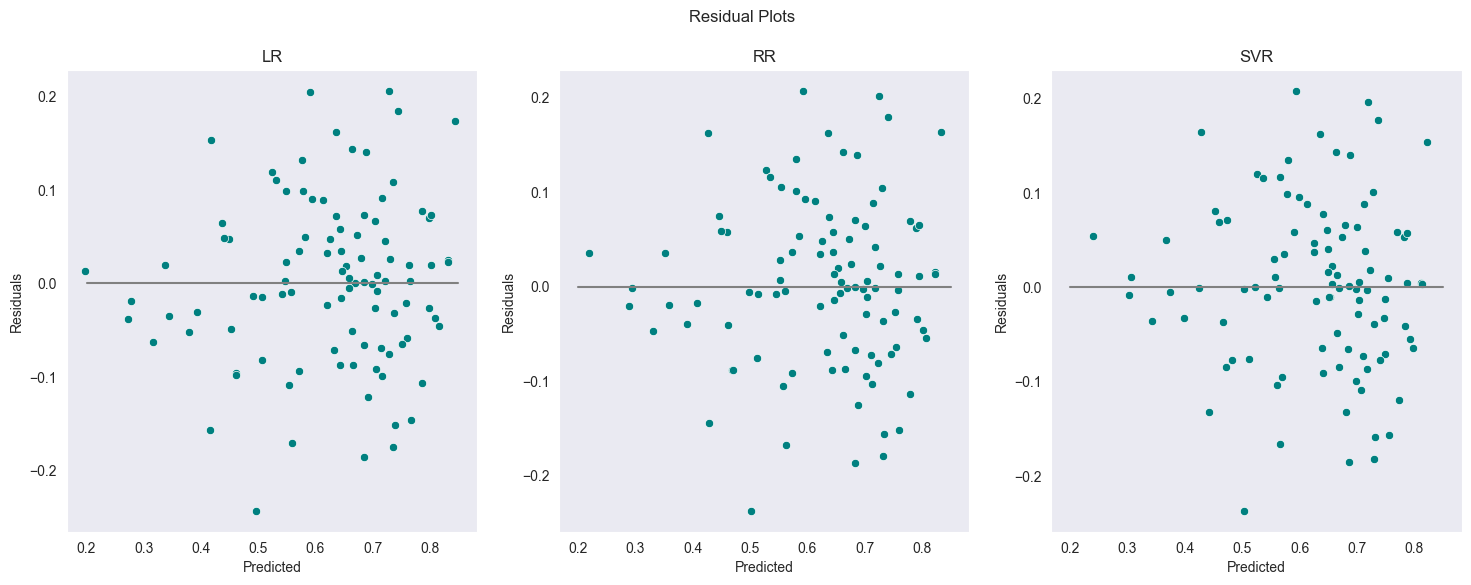

In [41]:
#PLOT RESIDUALS FOR EACH MODEL:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))

#plot:
sns.scatterplot(x=grid1.predict(x),y=(grid1.predict(x)-y),color='teal',ax=ax1)
sns.lineplot(y=0,x=[0.2,0.85],color='gray', ax=ax1)
sns.scatterplot(x=grid2.predict(x),y=(grid2.predict(x)-y),color='teal',ax=ax2)
sns.lineplot(y=0,x=[0.2,0.85],color='gray', ax=ax2)
sns.scatterplot(x=grid3.predict(x),y=(grid3.predict(x)-y),color='teal',ax=ax3)
sns.lineplot(y=0,x=[0.2,0.85],color='gray', ax=ax3)
#set titles:
ax1.set_title('LR')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
ax2.set_title('RR')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Residuals')
ax3.set_title('SVR')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Residuals')
plt.suptitle('Residual Plots',)
#show plots
plt.show()

The residuals for all three models appear to be distributed randomly and symmetrically around 0 for all ranges of predictions, which shows that there are no fundamental fault with the model or no patterns in the data uncaptured.<br><br>
Next we inspect how well each model fit the data:

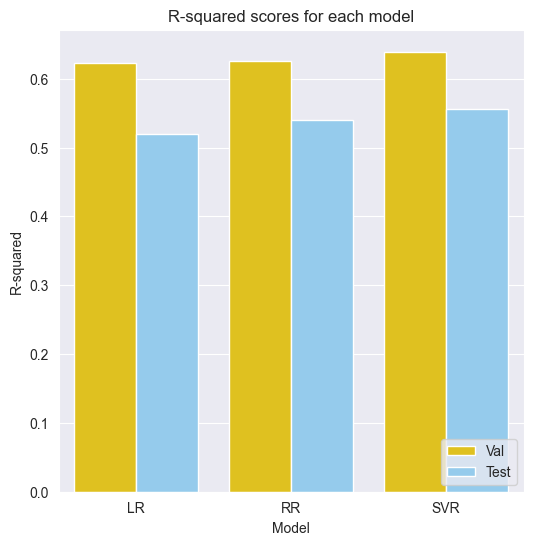

In [42]:
#VISUALISE MODEL SCORE:
plt.figure(figsize=(6,6))
sns.set_style('darkgrid')
sns.barplot(model_scores,x='Model',y='R-squared',hue='Score Type',palette=['gold','lightskyblue'])
plt.title('R-squared scores for each model')
plt.legend(loc = 'lower right')
plt.show()

It is evident from the visualisation above that the third model (SVR) fits the data the best. It was the most precise both in cross validation and in predicting unseen test data compared to the other two models. Approximately 64% of the variation in energy measurement can be predicted using SVR tuned with the following parameters: {'model__C': 0.007, 'model__epsilon': 0.001, 'model__kernel': 'linear', 'poly__degree': 1}
<br><br> Therefore, this will be our selected model to predict song energy.

Now we can define a function which uses our selected model to predict the energy measurement of a few songs:


In [50]:
def predict_energy(song):
    pred = grid3.predict(df[df['Song']==song][['acousticness','loudness']])[0]
    true = float(df.loc[df['Song']==song,'energy'])
    print(f'Predicted: {pred}\nTrue: {true}')

In [51]:
predict_energy('Lovely')

Predicted: 0.3069193932108689
True: 0.296


In [52]:
predict_energy('Yellow')

Predicted: 0.6509814795030868
True: 0.661


This concludes our predictive analysis section. Our selected model can be used to predict the energy level of new most streamed pop songs, which could be helpful in recommending new songs to Spotify listeners based on mood (For example, in an upbeat playlist, we will only include songs with predicted energy level of 0.5 or above, etc.).

# Conclusion
The key takeaways from this project were:
- For new songs to have a high chance of being popular, they should be between 3-3.5 minutes, and have a loudness level of around -6 dB.
- A song's perceived energy level depends mainly on 2 factors: its loudness and the amount of acoustic elements present within the song. The louder and less acoustic a song is, the more energetic it feels.
- A support vector regression model can be built to predict energy with up to 64% precision.